## STK-IN9300 - Assignment 2
### By: Oda Langrekken

### Github repo: https://github.com/OdaLangrekken/STK-IN9300

In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import cross_validate, cross_val_score, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.tree import DecisionTreeRegressor, plot_tree

import statsmodels.api as sm

# Import self-made code
import os
import sys

current_path = os.getcwd()
sys.path.append(current_path)
from subset_selection import forward_selection, backward_selection
from bootstrap import make_bootstrap_sample

# Problem 1. Regression

In the first part of the assigment we consider a dataset on aquatic toxicity, which contains descriptions of different chemicals. The **LC50** variable says what concentration of chemical that will cause 50% of Daphnia Magna (a small planktonic crustacean) to die within the next 48 hours. This variable will be our response. 

The dataset also contains 8 columns of molecular descriptions of the chemical, which we will treat as the predictors. 

Our goal is to build a model that captures the relationshop between the predictors and the response. Because our response variable is continuous, we treat this as a regression problem. Let us have a look at the data before we start modelling.

In [2]:
# Read data
df = pd.read_csv('Data/qsar_aquatic_toxicity.csv', header=None, delimiter=';')
df.columns = ['TPSA', 'SAacc', 'H050', 'MLOGP', 'RDCHI', 'GATS1p', 'nN', 'C040', 'LC50']
df.head()

,TPSA,SAacc,H050,MLOGP,RDCHI,GATS1p,nN,C040,LC50
0,0.00,0.0,0,2.419,1.225,0.667,0,0,3.740
1,0.00,0.0,0,2.638,1.401,0.632,0,0,4.330
2,9.23,11.0,0,5.799,2.930,0.486,0,0,7.019
3,9.23,11.0,0,5.453,2.887,0.495,0,0,6.723
4,9.23,11.0,0,4.068,2.758,0.695,0,0,5.979


We see that our data contains numerical variables only. **H050**, **nN** and **C040** are discrete as they count the number of atoms, while the rest of the variables are continuous.

To explore the data further we plot a correlation heatmap. 

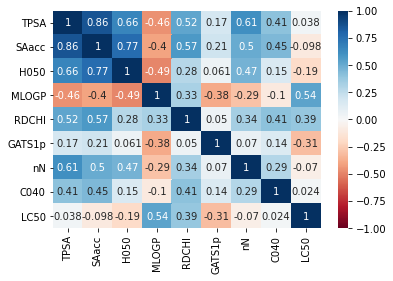

In [3]:
sns.heatmap(df.corr(), cmap='RdBu', vmin=-1, vmax=1, annot=True);

It is time to start preparing the data for modelling. For this first part I will mostly use the `statmodels` library. This library does not automatically add the intercept, so the intercept is added before modelling.

The data is also slit into a train and test set. Approximately 2/3 of the data is used for training, while the remaining 1/3 is saved for testing. Where it is useful I have specified the random state used for splitting, such that the same split will be obtained every time the code is run.

In [4]:
# Add intercept
df.insert(0, 'bias', 1)

# Split the dataframe into matrix of precictors and array of respones
X = df.drop('LC50', axis=1)
y = df['LC50']

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

### Part 1. Linear models

In this first part I will fit a linear model to the data. Our model is on the form $y=\beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p$, where $X_j$ is the $jth$ predictor. The model is fit to the data by finding the coefficients $\boldsymbol\beta$ that minimizes the residual sum of squares.

Two models will be fit. One with the count variables as is, and one model where they are codified as 0 in the absence of atoms and 1 in the presense of atoms. The models will be compared. To assess the explainability of the models I will use mean squared error.

In [5]:
# Create dichtomized data
X_train_dic = X_train.copy(deep=True)
X_test_dic = X_test.copy(deep=True)

for col in ['H050', 'nN', 'C040']:
    X_train_dic[col] = X_train_dic[col].apply(lambda x: 1 if x >= 1 else 0)
    X_test_dic[col] = X_test_dic[col].apply(lambda x: 1 if x >= 1 else 0)

In [6]:
# Fit model with linear count variables
linear_model = sm.OLS(y_train, X_train)
lm_result = linear_model.fit()

# Fit model with dichotomized count variables
linear_model_dic = sm.OLS(y_train, X_train_dic)
lm_result_dic = linear_model_dic.fit()

# Make predictions and find errors
y_pred_test = lm_result.predict(X_test)
y_pred_train = lm_result.predict(X_train)

mse_test = mean_squared_error(y_pred_test, y_test)
mse_train = mean_squared_error(y_pred_train, y_train)

y_pred_test_dic = lm_result.predict(X_test_dic)
y_pred_train_dic = lm_result.predict(X_train_dic)

mse_test_dic = mean_squared_error(y_pred_test_dic, y_test)
mse_train_dic = mean_squared_error(y_pred_train_dic, y_train)

# Make dataframe with coefficient significances
print('Significance of coefficients')
coeffs = pd.concat([lm_result.pvalues, lm_result_dic.pvalues], axis=1)
coeffs.columns = ['Linear', 'Dichotomized']
coeffs

Significance of coefficients


,Linear,Dichotomized
bias,4.649549e-15,8.804597e-15
TPSA,2.723733e-14,2.709814e-10
SAacc,1.273452e-08,5.376487e-08
H050,7.678335e-01,4.998146e-01
MLOGP,1.276758e-06,3.205810e-07
RDCHI,6.416074e-05,5.607924e-04
GATS1p,3.947420e-03,5.240288e-03
nN,7.275074e-05,9.662588e-01
C040,7.684670e-01,7.319797e-01


In [7]:
# Print errors
print('Mean squared errors')
print(f'Train linear: {mse_train:.4f}')
print(f'Test linear: {mse_test:.4f}')
print(f'Train dichotomized: {mse_train_dic:.4f}')
print(f'Test dichotomized: {mse_test_dic:.4f}')

Mean squared errors
Train linear: 1.5088
Test linear: 1.2826
Train dichotomized: 1.6150
Test dichotomized: 1.4031


**Comments** 

By analyzing the errors we can conclude that the model seems to peform better when the count variables are linear. Information is lost when we dichotomize the variables, as we end up with two categories instead of a range of different values. Thus it is not surprising that the dichotomized model performs worse. 

For both models the train error is higher than the test error. As high variance is common when using least squares estimates, this is a bit surprising. 

Finally we consider the significance of the coefficients (see table above). For **H050** and **C040** the significances are of the same order for both models. The **nN** significance is however significantly higher for the linear model, which supports our theory that information is lost when dichotomizing. 

Another variable that shows a big difference in significance is **TPSA**. This variable is correlated with the count variables (see correlation plot above), so a change in these variables will probably affect the importance of **TPSA**.


### Part 2. Computing average test error on 200 runs

I will now repeat what was done in part 1 for 200 times. Each time there will be a different split in train and test sets. The final reported errors are the averages over all runs.

In [8]:
train_errors = []
test_errors = []

train_errors_dic = []
test_errors_dic = []


for i in range(200):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    X_train_dic = X_train.copy(deep=True)
    X_test_dic = X_test.copy(deep=True)

    for col in ['H050', 'nN', 'C040']:
        X_train_dic[col] = X_train_dic[col].apply(lambda x: 1 if x >= 1 else 0)
        X_test_dic[col] = X_test_dic[col].apply(lambda x: 1 if x >= 1 else 0)

    linear_model = sm.OLS(y_train, X_train)
    lm_result = linear_model.fit()
    
    linear_model_dic = sm.OLS(y_train, X_train_dic)
    lm_result_dic = linear_model_dic.fit()
    
    y_pred_test = lm_result.predict(X_test)
    y_pred_train = lm_result.predict(X_train)

    mse_test = mean_squared_error(y_pred_test, y_test)
    mse_train = mean_squared_error(y_pred_train, y_train)

    y_pred_test_dic = lm_result.predict(X_test_dic)
    y_pred_train_dic = lm_result.predict(X_train_dic)

    mse_test_dic = mean_squared_error(y_pred_test_dic, y_test)
    mse_train_dic = mean_squared_error(y_pred_train_dic, y_train)
    
    train_errors.append(mse_train)
    test_errors.append(mse_test)
    
    train_errors_dic.append(mse_train_dic)
    test_errors_dic.append(mse_test_dic)
    
# Find averages
mse_train = np.mean(train_errors)
mse_test = np.mean(test_errors)

mse_train_dic = np.mean(train_errors_dic)
mse_test_dic = np.mean(test_errors_dic)

# Print errors
print('Mean squared errors')
print(f'Train linear: {mse_train:.4f}')
print(f'Test linear: {mse_test:.4f}')
print(f'Train dichotomized: {mse_train_dic:.4f}')
print(f'Test dichotomized: {mse_test_dic:.4f}')


Mean squared errors
Train linear: 1.4054
Test linear: 1.5053
Train dichotomized: 1.4934
Test dichotomized: 1.5770


**Comments** 

The results are mostly consistent with our comments on part 1. Information is lost when dichotomizing, so the linear model performs better. Now we see that the test error is higher than the train error for both models. Probably there is some quality if the train and test sets from part 1 that makes the model perform surpisingly well on the test set.    

### Part 3. Variable selection procecures

We saw in the last part that our model seems to have some variance, since the test error is higher than the train error. Finding the model that has the best balance between low bias and low variance is called model selection. We will now consider the subset selection method for model selection. 

Complex models with many predictors typically have larger variance. The goal of subset selection is to decrease the number of predictors by only using the ones that most improve the fit. 

In forward selection we start with a model containing just the intercept, and then add the predictor that improves the explaining power of our model the most. We stop adding new columns when a certain criterion is met. Here we use increasing AIC/BIC as stopping criteria. 

In backward selection we start with the full model, and then remove the predictor with the largest p-value. Again we stop removing columns when a criterion is met. 

In [9]:
# Make new split of data, same as in part 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

# Make model using forward selection with AIC as criterion
df = forward_selection(X_train, y_train, 'AIC')
df

,bias,MLOGP,TPSA,SAacc,nN,RDCHI,GATS1p,H050
473,1,-0.329,91.49,117.376,5,1.868,1.621,5
62,1,0.996,37.30,67.828,0,1.746,1.547,1
427,1,2.066,12.89,16.786,1,2.284,0.867,0
111,1,3.213,82.48,37.550,1,2.806,1.172,0
84,1,3.562,0.00,0.000,0,2.281,1.150,0
...,...,...,...,...,...,...,...,...
211,1,1.672,0.00,0.000,0,1.225,0.562,0
502,1,1.364,0.00,0.000,0,1.155,0.576,0
537,1,3.112,56.15,36.022,2,2.997,0.701,2
196,1,3.210,0.00,0.000,0,1.924,0.788,0


In [10]:
# Make model using forward selection with BIC as criterion
df = forward_selection(X_train, y_train, 'BIC')
df

,bias,MLOGP,TPSA,SAacc,nN,RDCHI,GATS1p,H050
473,1,-0.329,91.49,117.376,5,1.868,1.621,5
62,1,0.996,37.30,67.828,0,1.746,1.547,1
427,1,2.066,12.89,16.786,1,2.284,0.867,0
111,1,3.213,82.48,37.550,1,2.806,1.172,0
84,1,3.562,0.00,0.000,0,2.281,1.150,0
...,...,...,...,...,...,...,...,...
211,1,1.672,0.00,0.000,0,1.225,0.562,0
502,1,1.364,0.00,0.000,0,1.155,0.576,0
537,1,3.112,56.15,36.022,2,2.997,0.701,2
196,1,3.210,0.00,0.000,0,1.924,0.788,0


**Comments**

Using forward selection we get the same model when using AIC and BIC as stopping criteria. The only predictor that is not included is **C040**. 

We know that BIC tends to favor simples models than AIC when many predictors are available. As we do not have that many predictors we get the same model. (It should be mentioned that forward selection with BIC resulted in a sparser model than for AIC when I tested with a different split in train and test set).

In [11]:
# Backward selection
df = backward_selection(X_train, y_train, 'AIC')
df

,bias,TPSA,SAacc,MLOGP,nN
473,1,91.49,117.376,-0.329,5
62,1,37.30,67.828,0.996,0
427,1,12.89,16.786,2.066,1
111,1,82.48,37.550,3.213,1
84,1,0.00,0.000,3.562,0
...,...,...,...,...,...
211,1,0.00,0.000,1.672,0
502,1,0.00,0.000,1.364,0
537,1,56.15,36.022,3.112,2
196,1,0.00,0.000,3.210,0


In [12]:
df = backward_selection(X_train, y_train, 'BIC')
df

,bias,TPSA,SAacc,MLOGP,nN
473,1,91.49,117.376,-0.329,5
62,1,37.30,67.828,0.996,0
427,1,12.89,16.786,2.066,1
111,1,82.48,37.550,3.213,1
84,1,0.00,0.000,3.562,0
...,...,...,...,...,...
211,1,0.00,0.000,1.672,0
502,1,0.00,0.000,1.364,0
537,1,56.15,36.022,3.112,2
196,1,0.00,0.000,3.210,0


**Comments**

Once more we get the same model for AIC and BIC. This time, using backward selection, we get a sparser model where only half of the original predictors are included.

### Part 4. Ridge regression

Another method for increasing variance is Ridge regression. Ridge regression penalizes the size of the regression coefficients. 

Ridge regression is sensitive to the scale of the input features so we scale the input before training.

As the test set should not be used for training, we cannot use it to find the best complexity parameter $\lambda$. Instead we use cross-validation and bootstrap. In cross-validation the training set is split into $K$ folds. The model is trained on all except one fold, and tested on the fold that was exluded from training. This is repeated for all folds. By averaging the error of all K models, we get an estimate of the prediciton error. 

Another method for estimating the prediction error is the bootstrap. By sampling from the original train set with replacement, boostrap generates pseudo data sets. A model is trained on each bootstrap sample, and the error is reported as the average over all samples. In my implementation of the bootstrap the rows not chosen in the sampling are used as a test set.


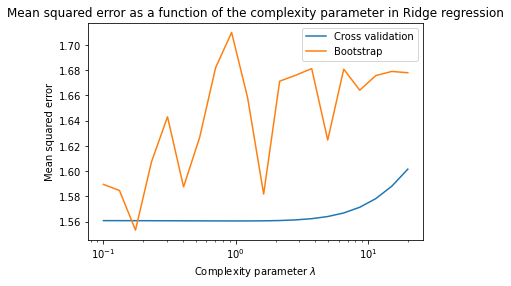

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=8)

# Scale data
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_errors_cv = []
train_errors_bs = []

best_error_cv = float('inf')
best_lambda_cv = 0

best_error_bs = float('inf')
best_lambda_bs = 0

# Loop over different lambdas
for lamb in np.logspace(-1,np.log10(20),20):
    ridge_model = Ridge(alpha=lamb)
    
    cv_scores = cross_validate(ridge_model, X_train_scaled, y_train, cv=5, scoring = "neg_mean_squared_error")
    cv_score = np.mean(cv_scores['test_score'])
    train_errors_cv.append(-cv_score)
    
    if -np.mean(cv_score) < best_error_cv:
        best_error_cv = -np.mean(cv_score)
        best_lambda_cv = lamb
        
    # Generate 20 bootstrap samples
    bs_errors = []
    for i in range(20):
        x_bs, y_bs, x_bs_test, y_bs_test = make_bootstrap_sample(X_train_scaled, y_train.reset_index(drop=True))
        ridge_model.fit(x_bs, y_bs)
        bs_predict = ridge_model.predict(x_bs_test)
        mse_bs = mean_squared_error(bs_predict, y_bs_test)
        bs_errors.append(mse_bs)
    train_errors_bs.append(np.mean(bs_errors))
    
plt.plot(np.logspace(-1,np.log10(20),20), train_errors_cv, label='Cross validation')
plt.plot(np.logspace(-1,np.log10(20),20), train_errors_bs, label='Bootstrap')
plt.legend()
plt.xscale('log')
plt.xlabel('Complexity parameter $\lambda$');
plt.ylabel('Mean squared error');
plt.title('Mean squared error as a function of the complexity parameter in Ridge regression');

The figure above shows the mean squarer error as a function of model complexity when using ridge regression. The predicted mean squarer error is estimated using both bootstrap and cross-validation. For cross-validation the curve is smooth and seems to have a minimum at a $\lambda$ of about 1. 

For bootstrap the error is very wobbly. It does not become smoother by increasing the number of bootstrap samples. This result is suprising to me, as I generally expect boostrap to have less variance than cross-validation. 

As I cannot explain the wobbliness of the boostrap estimates, I trust the cross-validation more. Below you can see a print out with the best parameter obtained by cross-validation. The test error is also reported for a model with this complexity parameter. We see that cross-validation overestimates the test error, which probably has the same cause as the low test error in part 1. The test error using Ridge regression is 1.326 compared to 1.2825 for least squares, so adding the penalty to the size of the coefficients seems to have helped reduce the variance.

In [14]:
print(f'Lowest error cross-validation: {best_error_cv:.4}')
print(f'Best complexity parameter cross-validation {best_lambda_cv:.4}')

ridge = Ridge(alpha=best_lambda_cv)
ridge.fit(X_train_scaled, y_train)
pred = ridge.predict(X_test_scaled)
mse = mean_squared_error(pred, y_test)
pred_train = ridge.predict(X_train_scaled)
mse_train = mean_squared_error(pred_train, y_train)
print(f'Test error using best complexity parameter: {mse:.4}')
print(f'Train error using best complexity parameter: {mse_train:.4}')

Lowest error cross-validation: 1.56
Best complexity parameter cross-validation 0.9308
Test error using best complexity parameter: 1.326
Train error using best complexity parameter: 1.494


### Part 5. Generalized additive model
By using a GAM we can add non-linear effect to the model. For fitting we use smoothing splines for all predictors.

In [15]:
from pygam import LinearGAM, s

GAM = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7))
GAM.fit(X_train, y_train)
pred = GAM.predict(X_test)
mse = mean_squared_error(pred, y_test)
pred_train = GAM.predict(X_train)
mse_train = mean_squared_error(pred_train, y_train)
print(f'GAM test error: {mse:.4}')
print(f'GAM train error: {mse_train:.4}')

GAM test error: 1.79
GAM train error: 1.094


When using a GAM with smoothing splines on all predictors the model overfits to a larger degree than for least squares and Ridge regression. This is to be expected, as adding non-linear terms increases the complexity of the model, which again can increase variance. To decrease the variance one could try subset selection to limit the amount of predictors.

### Part 6. Regression tree
Finally we fit a model using a regression tree. Decision trees are vey prone to high variance. To reduce the variance I add cost-complexity pruning to the model (the `ccp_alpha` parameter), which reduces the size of the tree and ensures that the model does not become too complex. 

The tree is plotted below. For the regression tree the test error is above 2, which is our highest error yet. 

Test error regression tree: 2.175


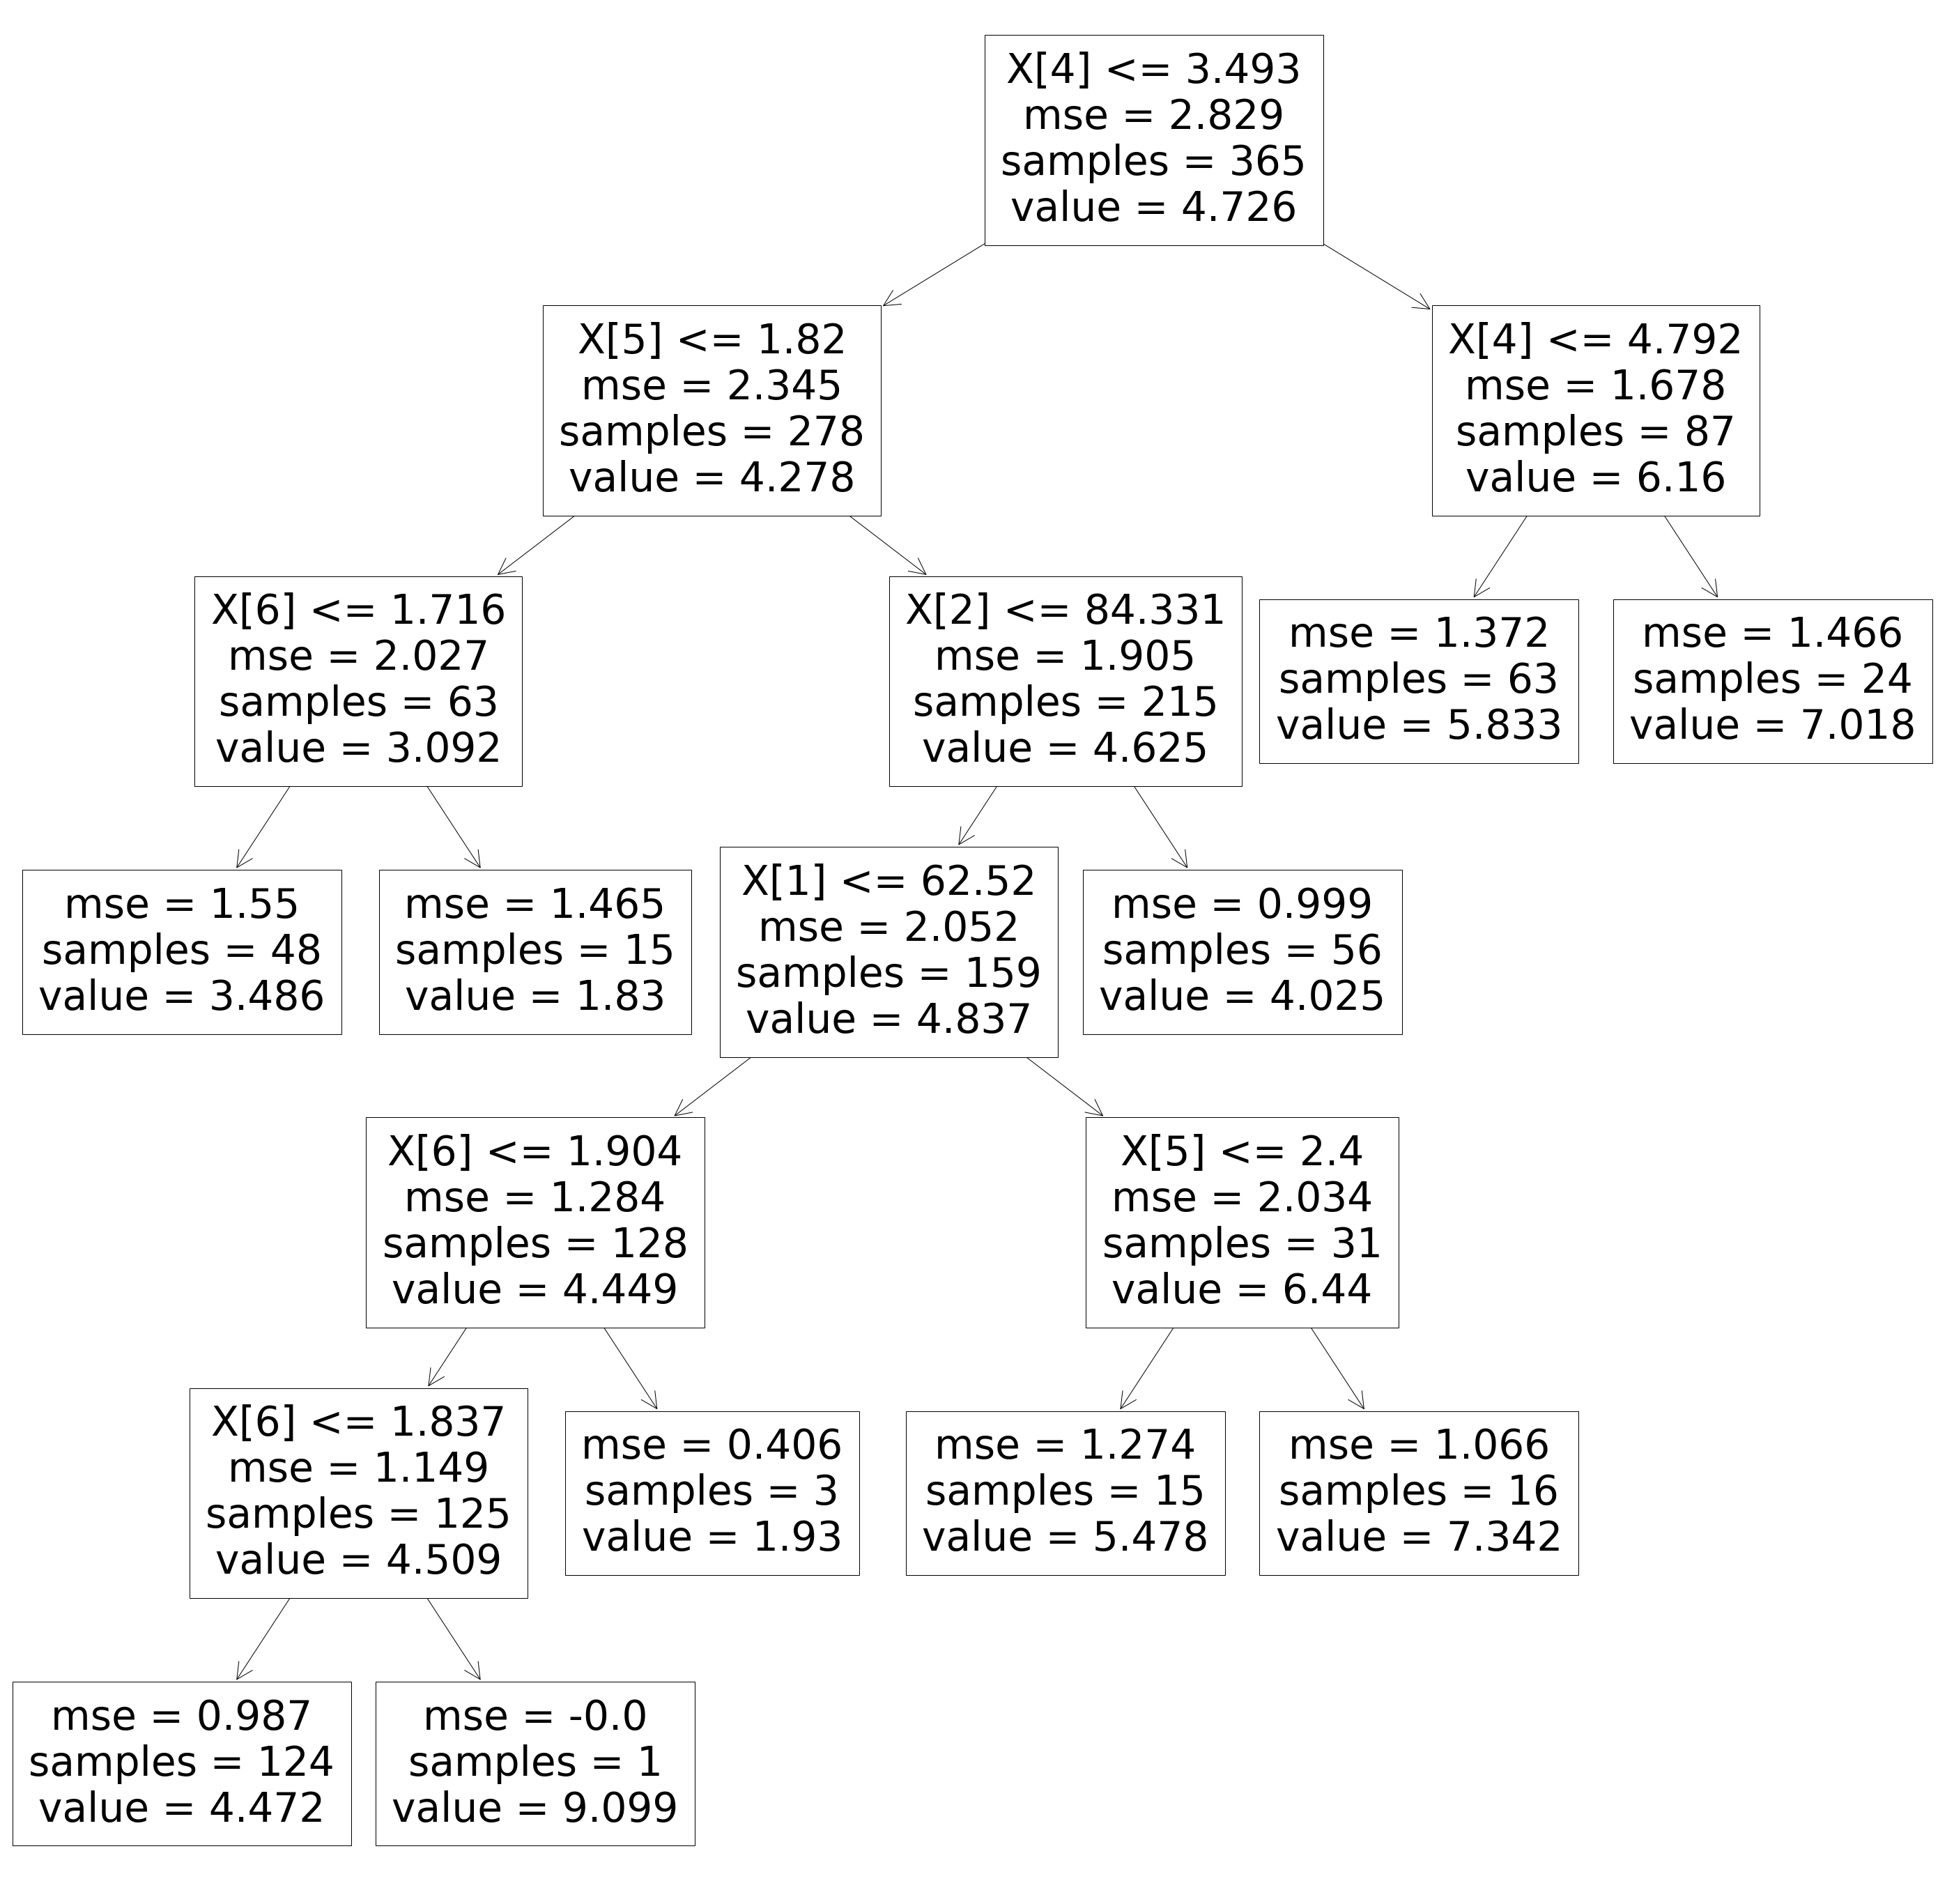

In [16]:
tree = DecisionTreeRegressor(ccp_alpha=0.05, random_state=7)
tree.fit(X_train, y_train)
pred = tree.predict(X_test)
mse = mean_squared_error(pred, y_test)
print(f'Test error regression tree: {mse:.4}')
plt.figure(figsize=(50, 50))
plot_tree(tree)
plt.show()

### Part 7. Regression wrap-up
We have tested several different methods for regression. Of the tested methods the regression tree has the highest error (2.175). The performance of the tree could probably have been improved with some model optimization but as regression trees can have high variance a single tree might not be the best fitted model for this problem. 

For Ridge regression we obtained a train error of about 1.494 and a test error of 1.326. For least squares the train error was 1.5088 and the test error 1.283. As the least squares estimates seem to have large variance, I have the most faith in the Ridge regression.  

# Problem 2. Classification

We now consider the Pima dataset, which contains information on 768 women including whether or not they have diabetes. As the response variable **diabetes** is categorical, this is a classification problem.

Let us have a first look at the data.

In [17]:
# Read the data 
df = pd.read_csv('Data/PimaIndiansDiabetes.csv').drop('Unnamed: 0', axis=1)
# Encode diabetes as 0 (neg) and 1 (pos)
df['diabetes'] = df['diabetes'].apply(lambda x: 1 if x=='pos' else 0)
df.head()

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


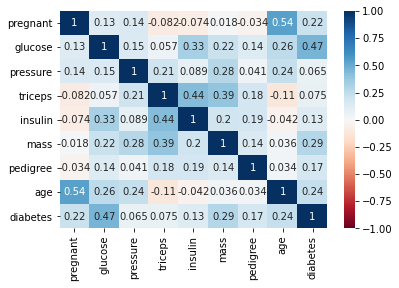

In [18]:
sns.heatmap(df.corr(),  cmap='RdBu', vmin=-1, vmax=1, annot=True);

In [19]:
X = df.drop('diabetes', axis=1)
y = df['diabetes']

## Split the data in train and test set, using 2/3 for train set.
## The stratify argument ensures equal portions of women with diabetes in both sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)

### Part 1. k-NN
The first model we train is a k-nearest neighbors model. We will use 5-fold and loo (leave-on-out) cross-validation to select the number of neighbors that lead to the best model (lowest mean squared error). 

In [20]:
cv_5_scores = []
loo_scores = []
test_scores = []

# Store best k 
best_k = 0
highest_accuracy = 0

# Find errors for k between 0 and 40

for k in range(1, 41):
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # 5-fold cross validation
    cv_5 = cross_validate(knn, X_train, y_train, cv=5)
    cv_5_score = np.mean(cv_5['test_score'])
    cv_5_scores.append(cv_5_score)
    
    # Leave one out
    loo_score = cross_val_score(knn, X_train, y_train, cv=LeaveOneOut())
    loo_scores.append(np.mean(loo_score))
    
    # Train model and find predicted y
    knn.fit(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    test_scores.append(test_score)
    
    # Update best k
    if highest_accuracy < cv_5_score:
        highest_accuracy = cv_5_score
        best_k = k

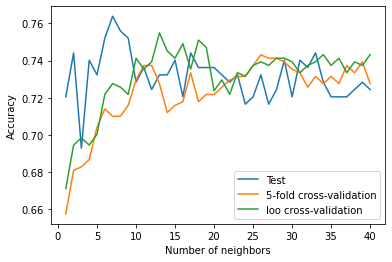

In [21]:
plt.plot(range(1, 41), test_scores, label='Test')
plt.plot(range(1, 41), cv_5_scores, label='5-fold cross-validation')
plt.plot(range(1, 41), loo_scores, label='loo cross-validation')
plt.legend();
plt.xlabel('Number of neighbors');
plt.ylabel('Accuracy');

In [22]:
print(f'Best value of k: {best_k}')
print(f'Cross-valdiation accuracy at best k: {highest_accuracy:.4}')
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
test_score = knn.score(X_test, y_test)
print(f'Test set accuracy at best k: {test_score:.4}')

Best value of k: 26
Cross-valdiation accuracy at best k: 0.7431
Test set accuracy at best k: 0.7323


Cross validation seems to be overestimating the accuracy slightly for larger k (greater than 20). This applies to both the 5-fold and the loo cross-validation. We see from the print out that the predicted error from cross-validation is higher than the test error at the best $k$. 

For loo the predicted accuracy is always somewhat higher. 

For smaller k both cross-validation methods underestimates the test error.

### Part 2. Generalized Additive Model

In [23]:
from pygam import LogisticGAM, s

GAM = LogisticGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7))
GAM.fit(X_train, y_train)
pred = GAM.predict(X_test)
acc = accuracy_score(pred, y_test)
pred_train = GAM.predict(X_train)
acc_train = accuracy_score(pred_train, y_train)
print(f'GAM test accuracy: {acc:.4}')
print(f'GAM train accuracy: {acc_train:.4}')

C:\Users\odala\anaconda3\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))
C:\Users\odala\anaconda3\lib\site-packages\pygam\pygam.py:591: RuntimeWarning: invalid value encountered in multiply
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *
C:\Users\odala\anaconda3\lib\site-packages\pygam\pygam.py:591: RuntimeWarning: overflow encountered in square
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *
C:\Users\odala\anaconda3\lib\site-packages\pygam\links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
C:\Users\odala\anaconda3\lib\site-packages\pygam\links.py:134: RuntimeWarning: invalid value encountered in true_divide
  return dist.levels * elp / (elp + 1)
C:\Users\odala\anaconda3\lib\site-packages\pygam\links.py:149: RuntimeWarning: overflow encountered in true_divide
  return dist.levels/(mu*(dist.levels - mu))


GAM test accuracy: 0.7756
GAM train accuracy: 0.8268


### Part 3. Classification trees, bagging etc.

We will now fit different tree-like models. A classification tree splits the data into subsets multiple times, before finally arriving at a prediction in the last split. This leads to a tree-like structure, where each split on a variable creates a new branch in the tree. If the tree becomes too large and complex the model tends to have high variance. 

Bagging (bootstrap aggregating) is a method that can reduce variance when using trees. Bootstrap samples are generated from the original train data and a tree is fitted for each sample. The predicted class is the class with the most votes from the bootstrap trees. 

Random forests add to bagging by also selecting only a subset of predictors for training for each tree. 

AdaBoost is based on boosting, which differs from bagging in that the trees are not independent of each other. The outcome from one tree is used as weights when fitting the second tree.

In [24]:
# Classifier tree
tree = DecisionTreeClassifier(random_state=7)
tree.fit(X_train, y_train)
score_tree = tree.score(X_test, y_test)
score_tree_train = tree.score(X_train, y_train)
print(f'Classifier tree accuracy (test): {score_tree:.4}')
print(f'Classifier tree accuracy (train): {score_tree_train:.4}')

# Bagging
bagg = BaggingClassifier(random_state=7)
bagg.fit(X_train, y_train)
score_bagg = bagg.score(X_test, y_test)
score_bagg_train = bagg.score(X_train, y_train)
print(f'Bagging accuracy (test): {score_bagg:.4}')
print(f'Bagging accuracy (train): {score_bagg_train:.4}')

# Random forest
forest = RandomForestClassifier(random_state=7)
forest.fit(X_train, y_train)
score_forest = forest.score(X_test, y_test)
score_forest_train = forest.score(X_train, y_train)
print(f'Random forest accuracy (test): {score_forest:.4}')
print(f'Random forest accuracy (train): {score_forest_train:.4}')

# AdaBoost
ada = AdaBoostClassifier(random_state=7)
ada.fit(X_train, y_train)
score_ada = ada.score(X_test, y_test)
score_ada_train = ada.score(X_train, y_train)
print(f'AdaBoost accuracy (test): {score_ada:.4}')
print(f'AdaBoost accuracy (train): {score_ada_train:.4}')

Classifier tree accuracy (test): 0.685
Classifier tree accuracy (train): 1.0
Bagging accuracy (test): 0.748
Bagging accuracy (train): 0.9864
Random forest accuracy (test): 0.7677
Random forest accuracy (train): 1.0
AdaBoost accuracy (test): 0.7559
AdaBoost accuracy (train): 0.8463


### Part 4. Comparing methods

First of all we notice the high variance of the classifier tree. The tree gets all predictions correct for the train set, but only about 69% correct for the test set.

With bagging the variance decreases, which is as expected when we average over more trees. 


Random forest does also get all predicitions correct on the train set, but the variance is not as high as for the classifier tree. Of the four models the random forest is the one with the highest test accuracy.

Finally AdaBoost is the model with the least variance. It does not perform as well on the train set as the other models, but it has a test accuracy that is only beat by the random forest.

Based on this result I would recomment the Random Forest or AdaBoost. The high variance of the Random Forest is a bit worrisome, so if I had to choose one model I would probably go with AdaBoost. All models are trained with default parameters. Using cross-validation to find the optimal parameters we could probably improve the performance of all models.

### Part 5. Comparing models using correct data

We now use a dataset where some implausible values are removed.

In [25]:
# Read the data 
df = pd.read_csv('Data/PimaIndiansDiabetes2.csv').drop('Unnamed: 0', axis=1)
# Encode diabetes as 0 (neg) and 1 (pos)
df['diabetes'] = df['diabetes'].apply(lambda x: 1 if x=='pos' else 0)

# Removing rows with missing values
df = df.dropna()

X = df.drop('diabetes', axis=1)
y = df['diabetes']

## Split the data in train and test set, using 2/3 for train set.
## The stratify argument ensures equal portions of women with diabetes in both sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)

# K-nearest neighbors
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
score_knn = knn.score(X_test, y_test)
score_knn_train = knn.score(X_train, y_train)
print(f'k-NN accuracy (test): {score_knn:.4}')
print(f'k-NN accuracy (train): {score_knn_train:.4}')

# Classifier tree
tree = DecisionTreeClassifier(random_state=7)
tree.fit(X_train, y_train)
score_tree = tree.score(X_test, y_test)
score_tree_train = tree.score(X_train, y_train)
print(f'Classifier tree accuracy (test): {score_tree:.4}')
print(f'Classifier tree accuracy (train): {score_tree_train:.4}')

# Bagging
bagg = BaggingClassifier(random_state=7)
bagg.fit(X_train, y_train)
score_bagg = bagg.score(X_test, y_test)
score_bagg_train = bagg.score(X_train, y_train)
print(f'Bagging accuracy (test): {score_bagg:.4}')
print(f'Bagging accuracy (train): {score_bagg_train:.4}')

# Random forest
forest = RandomForestClassifier(random_state=7)
forest.fit(X_train, y_train)
score_forest = forest.score(X_test, y_test)
score_forest_train = forest.score(X_train, y_train)
print(f'Random forest accuracy (test): {score_forest:.4}')
print(f'Random forest accuracy (train): {score_forest_train:.4}')

# AdaBoost
ada = AdaBoostClassifier(random_state=7)
ada.fit(X_train, y_train)
score_ada = ada.score(X_test, y_test)
score_ada_train = ada.score(X_train, y_train)
print(f'AdaBoost accuracy (test): {score_ada:.4}')
print(f'AdaBoost accuracy (train): {score_ada_train:.4}')

k-NN accuracy (test): 0.7538
k-NN accuracy (train): 0.771
Classifier tree accuracy (test): 0.7077
Classifier tree accuracy (train): 1.0
Bagging accuracy (test): 0.7692
Bagging accuracy (train): 0.9656
Random forest accuracy (test): 0.7769
Random forest accuracy (train): 1.0
AdaBoost accuracy (test): 0.7692
AdaBoost accuracy (train): 0.9275


The accuracy results are similar to before. What stands out the most is the large increase in the train accuracy for AdaBoost. The test accuracy also increases slightly. This strenghtens my confidence in AdaBoost, and shows the importance of data cleaning. No model will perform well on incorrect data.